# Segmenting and Clustering Neighborhoods in Toronto

## Scrape and Explore Toronoto Neighbourhood Data

In [136]:
import pandas as pd # library for data analysis
import requests # library to handle requests
from bs4 import BeautifulSoup as bs # library to parse HTML documents

url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data  = requests.get(url).text
soup = bs(data,"html5lib")

In [137]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighbourhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [138]:
df

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [139]:
df.shape

(103, 3)

#### Combine Address Details into One Column for Geolocator

In [140]:
df['Address'] = df[df.columns[0:]].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)
df

,Postal Code,Borough,Neighbourhood,Address
0,M3A,North York,Parkwoods,"M3A,North York,Parkwoods"
1,M4A,North York,Victoria Village,"M4A,North York,Victoria Village"
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A,Downtown Toronto,Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A,North York,Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government,"M7A,Queen's Park,Ontario Provincial Government"
...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North","M8X,Etobicoke,The Kingsway, Montgomery Road, O..."
99,M4Y,Downtown Toronto,Church and Wellesley,"M4Y,Downtown Toronto,Church and Wellesley"
100,M7Y,East Toronto Business,Enclave of M4L,"M7Y,East Toronto Business,Enclave of M4L"
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...","M8Y,Etobicoke,Old Mill South, King's Mill Park..."


In [141]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
df['location'] = df['Address'].apply(geocode)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

In [142]:
df # the geocoder does not fill in the location values because the addresses are ambiguous

,Postal Code,Borough,Neighbourhood,Address,location,point,latitude,longitude,altitude
0,M3A,North York,Parkwoods,"M3A,North York,Parkwoods","(Parkwoods Village Drive, Don Valley East, Nor...","(43.7578464, -79.3159749, 0.0)",43.757846,-79.315975,0.0
1,M4A,North York,Victoria Village,"M4A,North York,Victoria Village",None,None,NaN,NaN,NaN
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A,Downtown Toronto,Regent Park, Harbourfront",None,None,NaN,NaN,NaN
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A,North York,Lawrence Manor, Lawrence Heights",None,None,NaN,NaN,NaN
4,M7A,Queen's Park,Ontario Provincial Government,"M7A,Queen's Park,Ontario Provincial Government",None,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North","M8X,Etobicoke,The Kingsway, Montgomery Road, O...",None,None,NaN,NaN,NaN
99,M4Y,Downtown Toronto,Church and Wellesley,"M4Y,Downtown Toronto,Church and Wellesley",None,None,NaN,NaN,NaN
100,M7Y,East Toronto Business,Enclave of M4L,"M7Y,East Toronto Business,Enclave of M4L",None,None,NaN,NaN,NaN
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...","M8Y,Etobicoke,Old Mill South, King's Mill Park...",None,None,NaN,NaN,NaN


In [143]:
latlng = pd.read_csv(r'C:\Users\44751\Downloads\geospatial_coordinates.csv')
latlng

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [144]:
df = pd.merge(df, latlng, on='Postal Code')
df

,Postal Code,Borough,Neighbourhood,Address,location,point,latitude,longitude,altitude,Latitude,Longitude
0,M3A,North York,Parkwoods,"M3A,North York,Parkwoods","(Parkwoods Village Drive, Don Valley East, Nor...","(43.7578464, -79.3159749, 0.0)",43.757846,-79.315975,0.0,43.753259,-79.329656
1,M4A,North York,Victoria Village,"M4A,North York,Victoria Village",None,None,NaN,NaN,NaN,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront","M5A,Downtown Toronto,Regent Park, Harbourfront",None,None,NaN,NaN,NaN,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights","M6A,North York,Lawrence Manor, Lawrence Heights",None,None,NaN,NaN,NaN,43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,"M7A,Queen's Park,Ontario Provincial Government",None,None,NaN,NaN,NaN,43.662301,-79.389494
...,...,...,...,...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North","M8X,Etobicoke,The Kingsway, Montgomery Road, O...",None,None,NaN,NaN,NaN,43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,"M4Y,Downtown Toronto,Church and Wellesley",None,None,NaN,NaN,NaN,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,"M7Y,East Toronto Business,Enclave of M4L",None,None,NaN,NaN,NaN,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...","M8Y,Etobicoke,Old Mill South, King's Mill Park...",None,None,NaN,NaN,NaN,43.636258,-79.498509


#### Drop Unwanted Columns

In [145]:
df = df.drop(['Address', 'location', 'altitude', 'point', 'latitude', 'longitude', 'Postal Code'], axis=1)
df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


#### Find Geo Coordiantes for Toronto

In [146]:
from geopy.geocoders import Nominatim

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="myGeocoder")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronoto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronoto are 43.6534817, -79.3839347.


#### Add Nieghbourhoods onto Toronto Map

In [147]:
import folium
map1 = folium.Map(
    location=[43.6534817, -79.3839347],
    tiles='cartodbpositron',
    zoom_start=11,
)
df.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]]).add_to(map1), axis=1)
map1

#### Define Foursquare Credentials and Version

In [194]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### Find the first neighbourhood in the list

In [178]:
df.loc[0, 'Neighbourhood']

'Parkwoods'

#### Find the neighbourhood latitude and longitude

In [150]:
neighbourhood_latitude = df.loc[0, 'Latitude'] # neighbourhood latitude value
neighbourhood_longitude = df.loc[0, 'Longitude'] # neighbourhood longitude value

neighbourhood_name = df.loc[0, 'Neighbourhood'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Run a Foursquare query of closest 100 venues in a 500m radius

In [151]:
# type your answer here
radius = 500
LIMIT = 100
VERSION = '20180605'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)

In [152]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60963a38f953bc7ec7ab115f'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

In [153]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Clean the json into a Pandas Dataframe

In [154]:
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-154-853095ed29fe>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [155]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


## Explore all Neighbourhoods in Toronto

#### Create a function to repeat the same process to all the neighbourhoods in Toronto

In [156]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [157]:
# type your answer here
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [158]:
print(toronto_venues.shape)
toronto_venues.head()

(2111, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [159]:
toronto_venues.groupby('Neighborhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
Willowdale South,33,33,33,33,33,33
Willowdale West,5,5,5,5,5,5
Woburn,5,5,5,5,5,5


In [160]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


## Analyse Venues in Each Neighbourhood

In [161]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
toronto_onehot.shape

(2111, 269)

In [163]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Willowdale South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0
94,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
95,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
96,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [164]:
toronto_grouped.shape

(98, 269)

#### Print each neighbourhood along with the top 5 most common venues

In [165]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge   0.2
1               Skating Rink   0.2
2  Latin American Restaurant   0.2
3             Breakfast Spot   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1             Gym  0.14
2    Skating Rink  0.14
3  Sandwich Place  0.14
4     Coffee Shop  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                venue  freq
0         Coffee Shop  0.10
1                Bank  0.10
2                Park  0.05
3    Sushi Restaurant  0.05
4  Frozen Yogurt Shop  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4        Movie Theater  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.08
2      Sandwich Place  0.08
3          Re

#### Create a new dataframe to display the top 10 venues for each neighborhood.

In [166]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [167]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Skating Rink,Pub,Sandwich Place,Gym,Airport Gate,Event Space,Escape Room,Electronics Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pizza Place,Supermarket,Deli / Bodega,Sushi Restaurant,Middle Eastern Restaurant,Ice Cream Shop,Shopping Mall,Mobile Phone Shop
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Women's Store,Dim Sum Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Coffee Shop,Italian Restaurant,Restaurant,Liquor Store,Pharmacy,Pub,Butcher,Café,Sushi Restaurant


In [168]:
neighbourhoods_venues_sorted.shape

(98, 11)

## K Means Clustering

#### Clustering based on the venues within each neighbourhood and the times they are visited. 

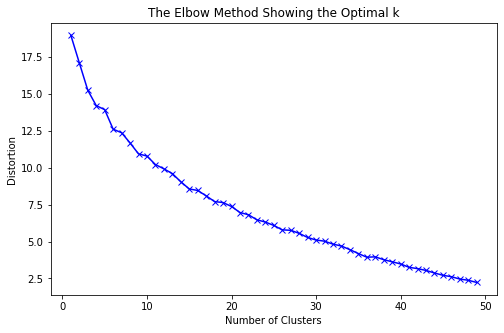

In [175]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

In [176]:
# set number of clusters
kclusters = 12

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [177]:
toronto_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,5.0,Park,Food & Drink Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Event Space
1,North York,Victoria Village,43.725882,-79.315572,1.0,Financial or Legal Service,Portuguese Restaurant,Coffee Shop,Pizza Place,Hockey Arena,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Gym / Fitness Center,Event Space,Restaurant
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Furniture / Home Store,Clothing Store,Accessories Store,Vietnamese Restaurant,Miscellaneous Shop,Boutique,Coffee Shop,Dog Run,Dim Sum Restaurant,Diner
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Burrito Place,Bar,Italian Restaurant,Japanese Restaurant,Beer Bar,Smoothie Shop,Sandwich Place


In [172]:
toronto_merged.shape

(103, 14)

In [179]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].fillna(0).astype(np.int64)

In [180]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Investigate the Venue Type within Each Cluster

In [181]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Lawrence Manor, Lawrence Heights",Furniture / Home Store,Clothing Store,Accessories Store,Vietnamese Restaurant,Miscellaneous Shop,Boutique,Coffee Shop,Dog Run,Dim Sum Restaurant,Diner
5,Islington Avenue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,"York Mills, Silver Hills",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,"Willowdale, Newtonbrook",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,Weston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,Upper Rouge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Financial or Legal Service,Portuguese Restaurant,Coffee Shop,Pizza Place,Hockey Arena,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,"Regent Park, Harbourfront",Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Gym / Fitness Center,Event Space,Restaurant
4,Ontario Provincial Government,Coffee Shop,Sushi Restaurant,Yoga Studio,Burrito Place,Bar,Italian Restaurant,Japanese Restaurant,Beer Bar,Smoothie Shop,Sandwich Place
7,Don Mills North,Athletics & Sports,Japanese Restaurant,Café,Caribbean Restaurant,Dessert Shop,Gym,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
9,"Garden District, Ryerson",Clothing Store,Coffee Shop,Middle Eastern Restaurant,Café,Japanese Restaurant,Italian Restaurant,Bubble Tea Shop,Cosmetics Shop,Pizza Place,Electronics Store
13,Don Mills South,Coffee Shop,Gym,Restaurant,Asian Restaurant,Italian Restaurant,Discount Store,Dim Sum Restaurant,Clothing Store,Chinese Restaurant,Café
15,St. James Town,Coffee Shop,Café,Gastropub,Cocktail Bar,Cosmetics Shop,Italian Restaurant,Restaurant,Park,Clothing Store,Moroccan Restaurant
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Café,Pharmacy,Beer Store,Convenience Store,Pizza Place,Liquor Store,Pet Store,Coffee Shop,Electronics Store,Colombian Restaurant
19,The Beaches,Trail,Pub,Health Food Store,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
20,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Farmers Market,Beer Bar,Seafood Restaurant,Restaurant,Pharmacy,Sporting Goods Shop


In [183]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Malvern, Rouge",Fast Food Restaurant,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


In [184]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
83,"Moore Park, Summerhill East",Restaurant,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega


In [185]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,"Humberlea, Emery",Baseball Field,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store,Farmers Market
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Baseball Field,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store,Farmers Market


In [186]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Park,Food & Drink Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Event Space
10,Glencairn,Park,Pizza Place,Bakery,Japanese Restaurant,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
16,Humewood-Cedarvale,Hockey Arena,Park,Field,Trail,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
21,Caledonia-Fairbanks,Park,Pool,Women's Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Escape Room,Deli / Bodega
40,Downsview East,Park,Airport,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
46,Downsview West,Grocery Store,Bank,Shopping Mall,Park,Golf Course,Escape Room,Eastern European Restaurant,Dumpling Restaurant,Greek Restaurant,Drugstore
49,"North Park, Maple Leaf Park, Upwood Park",Park,Bakery,Construction & Landscaping,Basketball Court,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
61,Lawrence Park,Park,Bus Line,Swim School,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Department Store
68,Forest Hill North & West,Park,Trail,Sushi Restaurant,Jewelry Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
77,"Kingsview Village, St. Phillips, Martin Grove ...",Park,Bus Line,Pizza Place,Sandwich Place,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


In [187]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"West Deane Park, Princess Gardens, Martin Grov...",Bakery,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Farmers Market


In [188]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough Village,Business Service,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


In [189]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Parkview Hill, Woodbine Gardens",Pizza Place,Gym / Fitness Center,Café,Athletics & Sports,Bank,Flea Market,Gastropub,Pharmacy,Intersection,Donut Shop
14,Woodbine Heights,Park,Skating Rink,Beer Store,Athletics & Sports,Intersection,Curling Ice,Bus Stop,Women's Store,Distribution Center,Diner
18,"Guildwood, Morningside, West Hill",Restaurant,Rental Car Location,Donut Shop,Breakfast Spot,Medical Center,Bank,Mexican Restaurant,Intersection,Electronics Store,Coworking Space
26,Cedarbrae,Hakka Restaurant,Bakery,Athletics & Sports,Bank,Thai Restaurant,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Women's Store,Discount Store
27,Hillcrest Village,Pool,Mediterranean Restaurant,Golf Course,Fast Food Restaurant,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
29,Thorncliffe Park,Indian Restaurant,Gym / Fitness Center,Supermarket,Restaurant,Pizza Place,Pharmacy,Park,Liquor Store,Intersection,Gym
31,"Dufferin, Dovercourt Village",Bakery,Pharmacy,Park,Furniture / Home Store,Liquor Store,Middle Eastern Restaurant,Music Venue,Café,Brewery,Bar
44,"Golden Mile, Clairlea, Oakridge",Bakery,Park,Ice Cream Shop,Bus Station,Bus Line,Metro Station,Intersection,Soccer Field,Gay Bar,Department Store
47,"India Bazaar, The Beaches West",Park,Fast Food Restaurant,Pub,Ice Cream Shop,Board Shop,Brewery,Sandwich Place,Italian Restaurant,Restaurant,Steakhouse
53,Downsview Central,Baseball Field,Food Truck,Home Service,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store


In [190]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Rouge Hill, Port Union, Highland Creek",Bar,Home Service,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dessert Shop
50,Humber Summit,Gym,Pizza Place,Home Service,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


In [191]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 10, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,"The Kingsway, Montgomery Road, Old Mill North",River,Park,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


In [192]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 11, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,The Danforth East,Park,Intersection,Convenience Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dessert Shop,Donut Shop
66,York Mills West,Park,Convenience Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Deli / Bodega
85,"Milliken, Agincourt North, Steeles East, L'Amo...",Park,Intersection,Playground,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
91,Rosedale,Park,Trail,Playground,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
